In [24]:
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split


In [71]:
class Incidents12(datasets.VisionDataset):
    def __init__(self, root, train_paths_and_labels, test_paths_and_labels, train=True, transform=None):
        super().__init__(root, transform=transform)

        self.train = train
        self.data = []
        self.targets = []
        self.errors = []

        # Load images from disk
        self.classes = os.listdir(root)[1:]

        paths_and_labels = train_paths_and_labels + test_paths_and_labels
        for (path, label) in paths_and_labels:
            try:
                img = Image.open(path).convert("RGB")
                self.data.append(img)
                self.targets.append(label)
            except (UnidentifiedImageError, FileNotFoundError):
                self.errors.append(path)

        # Resampling to equalize the amount of samples per class
        classes_count = {i: 0 for i in range(len(self.classes))}
        for target in self.targets:
            classes_count[target] += 1
        min_class = min(classes_count, key=classes_count.get)

        df = pd.DataFrame(data={"Image": self.data, "Label": self.targets})
        samples_class = [df[df["Label"] == i] for i in range(len(self.classes))]
        classes_under = [samples_class[i].sample(df[df["Label"] == min_class].shape[0]) for i in range(len(self.classes))]
        new_df = pd.concat(classes_under, axis=0).reset_index()
        self.data = new_df["Image"]
        self.targets = new_df["Label"]

        if train:
            images_and_labels = [(i, l) for (i, l) in images_and_labels if i.filename in train_paths]
        else:
            images_and_labels = [(i, l) for (i, l) in images_and_labels if i.filename in test_paths]

        self.data = [i for (i, _) in images_and_labels]
        self.targets = [l for (_, l) in images_and_labels]

    def __getitem__(self, index: int): 
        img, target = self.data[index], self.targets[index]

        if self.transform is not None:
            img = self.transform(img)
            img = img.numpy().transpose((1,2,0))

        return img, target

    def __len__(self):
        return(len(self.data))

    def to_dataframe(self):
        tensor_images = [self[i][0] for i in range(len(self.data))]
        return(pd.DataFrame(data={"Image": tensor_images, "Label": self.targets}))

In [72]:
transform = transforms.Compose([
    # center-crop
    transforms.CenterCrop(224),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.04544269, 0.04544269, 0.04544269],
                         [0.21317291, 0.21317291, 0.21317291])
])

In [73]:
image_dir = "./datasets/incidents/"
classes = os.listdir(image_dir)[1:]
paths = [image_dir + classes[i] + "/" for i in range(len(classes))]

images = []
labels = []

for p in paths:
    for path, dirs, files in os.walk(p):
        for filename in files:
            images.append(p + filename)
            labels.append(paths.index(p))

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=42)
train_paths_and_labels = list(zip(X_train, y_train))
test_paths_and_labels = list(zip(X_test, y_test))

In [74]:
train_set = Incidents12(image_dir, train_paths_and_labels,
                        test_paths_and_labels, train=True, transform=transform)
test_set = Incidents12(image_dir, train_paths_and_labels,
                       test_paths_and_labels, train=False, transform=transform)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


AttributeError: filename

In [60]:
def imshow(inp, title=None):
    mean = np.array([0.04544269, 0.04544269, 0.04544269])
    std = np.array([0.21317291, 0.21317291, 0.21317291])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

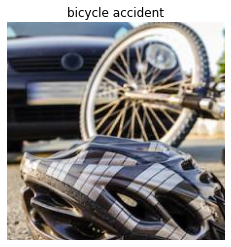

In [61]:
import random
r = random.randint(0,len(train_set.data))
imshow(train_set[r][0], train_set.classes[train_set[r][1]])

In [77]:
# df = train_set.to_dataframe()
# df
type(train_set.data[0])

PIL.Image.Image

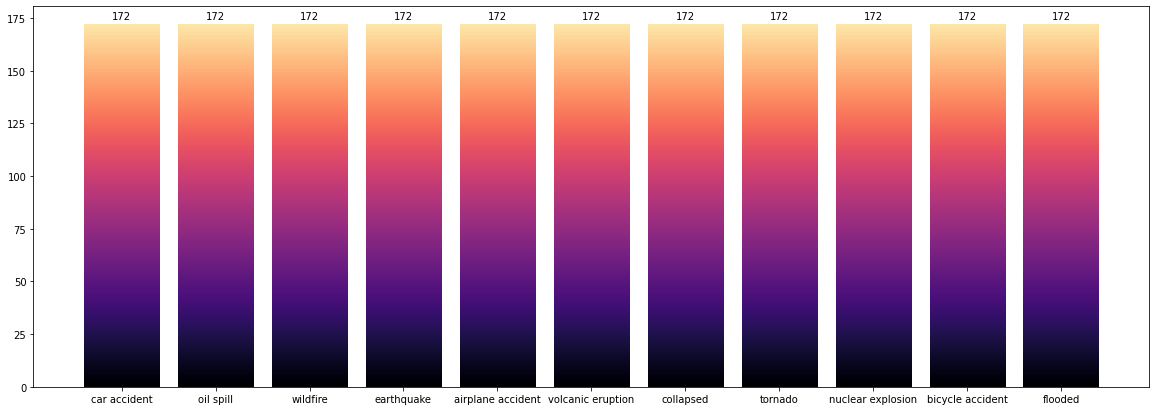

In [67]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
rects = plt.bar(train_set.classes,df["Label"].value_counts().sort_index())

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, '%d'%int(height),
                ha='center', va='bottom')
autolabel(rects)

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin=ymin, vmax=ymax, cmap='magma')
    ax.axis([xmin, xmax, ymin, ymax])

gradientbars_sliced(rects)
plt.show()

 ### Neural network